<a href="https://colab.research.google.com/github/AyeshaAnzerBCIT/3DPoseASDDetection/blob/main/Multitask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install google-cloud-storage


In [2]:
from google.colab import auth
auth.authenticate_user()


In [34]:
import os
import random
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, resnet18, mobilenet_v2, efficientnet_b0, ResNet50_Weights, ResNet18_Weights, MobileNet_V2_Weights, EfficientNet_B0_Weights
from sklearn.metrics import classification_report
import copy
from google.cloud import storage # Import the storage module from the google.cloud package
from io import StringIO
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Set Device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
# Define GCS bucket name and dataset folder path
BUCKET_NAME = "mmasd"

In [8]:
# Initialize Google Cloud Storage client
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

In [10]:

#   List All Files to Verify Folder Structure
all_files = [blob.name for blob in bucket.list_blobs()]  # List everything in the bucket

# Debugging: Print the first 10 file paths to verify structure
print(f"Total files found in GCS: {len(all_files)}")
print("Sample file paths in GCS:")
for file in all_files[:10]:  # Show first 10 files
    print(file)

Total files found in GCS: 3276
Sample file paths in GCS:
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_4_0.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_5_1.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_7_0.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_001_n_4_1.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_001_n_9_0.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_002_n_3_0.csv
3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Sub

In [11]:
# Extract Only CSV Files from Correct Folder
csv_files = [file for file in all_files if file.endswith(".csv")]

# Debugging: Ensure CSV files are detected
print(f"\nTotal CSV files found: {len(csv_files)}")
print("Sample CSV files:", csv_files[:5])  # Show first 5 CSV files


Total CSV files found: 3276
Sample CSV files: ['3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_4_0.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_5_1.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_000_i_7_0.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_001_n_4_1.csv', '3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/Arm_Swing/processed_Arm_swingas_20583_D16_001_n_9_0.csv']


In [12]:
#  Initialize ASD label counter
asd_label_counts = Counter()

In [21]:
#  Process Each CSV File
for file_path in csv_files:
    print(f"\nProcessing: {file_path}")  # Show which file is being processed

    try:
        blob = bucket.blob(file_path)
        content = blob.download_as_text()
        data = pd.read_csv(StringIO(content))

        # Ensure column names are properly formatted
        data.columns = data.columns.str.strip()

        # Debugging: Print first few rows of the CSV
        print("Sample data:")
        print(data.head())

        # Extract ASD_Label column and update counter
        if "ASD_Label" in data.columns:
            asd_label = int(data['ASD_Label'].iloc[0])
            asd_label_counts[asd_label] += 1
        else:
            print(f"Skipping {file_path}: 'ASD_Label' column not found")

    except Exception as e:
        print(f"Skipping {file_path} due to error: {e}")

Streaming output truncated to the last 5000 lines.
   Right_foot_y  Right_foot_z  Action_Label  ASD_Label  
0     -0.147181      0.563491             2          1  
1     -0.147636      0.593341             2          1  
2     -0.177310      0.597416             2          1  
3     -0.155776      0.631506             2          1  
4     -0.143927      0.638879             2          1  

[5 rows x 77 columns]

Processing: 3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/3_75 ELEMENTS LABLES_MEDIAPIPE_Final_to_Submit/chest_expansion/processed_ce_40023_D8_003_y_8_0.csv
Sample data:
     nose_x    nose_y    nose_z  left_eye_x  left_eye_y  left_eye_z  \
0  0.541515  0.553082  0.561911    0.494378    0.571903    0.467519   
1  0.541060  0.552545  0.561525    0.493277    0.571911    0.466685   
2  0.537468  0.549791  0.558633    0.490462    0.571730    0.466135   
3  0.535443  0.548123  0.556567    0.488997    0.570988    0.465422   
4  0.533573  0.546865  0.554996    0.487625    0.570471  

In [22]:
# Display ASD Label Counts
print("\nUnique ASD labels and counts:")
if not asd_label_counts:
    print("No ASD labels found.")
else:
    for label, count in asd_label_counts.items():
        print(f"ASD_Label = {label} --> {count} samples")



Unique ASD labels and counts:
ASD_Label = 0 --> 1315 samples
ASD_Label = 1 --> 1258 samples
ASD_Label = 6 --> 1 samples
ASD_Label = 2 --> 697 samples
ASD_Label = 3 --> 5 samples


In [23]:
# Balance Dataset (Equal ASD and Non-ASD Samples)
asd_counts = {0: [], 1: []}

for file_path in csv_files:
    try:
        blob = bucket.blob(file_path)
        content = blob.download_as_text()
        data = pd.read_csv(StringIO(content))

        asd_label = int(data['ASD_Label'].iloc[0])
        asd_label = 1 if asd_label >= 1 else 0  # Convert to binary ASD classification
        asd_counts[asd_label].append(file_path)
    except Exception as e:
        print(f"Skipping corrupted file: {file_path} due to {e}")
        continue

# Ensure both classes have the same number of samples
min_count = min(len(asd_counts[0]), len(asd_counts[1]))
balanced_files = random.sample(asd_counts[0], min_count) + random.sample(asd_counts[1], min_count)
random.shuffle(balanced_files)

print(f"Balanced dataset with {min_count} samples per class.")

Balanced dataset with 1315 samples per class.


In [24]:
#  Stratified Train-Validation-Test Split
labels = []
for file_path in balanced_files:
    blob = bucket.blob(file_path)
    content = blob.download_as_text()
    data = pd.read_csv(StringIO(content))

    asd_label = int(data['ASD_Label'].iloc[0])
    asd_label = 1 if asd_label >= 1 else 0
    labels.append(asd_label)

# Split dataset (80% train, 20% test)
train_files, test_files, train_labels, test_labels = train_test_split(
    balanced_files, labels, test_size=0.2, stratify=labels, random_state=42
)

# Split train into train (90%) and validation (10%)
train_files, val_files, _, _ = train_test_split(
    train_files, train_labels, test_size=0.1, stratify=train_labels, random_state=42
)

print(f"Train: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}")


Train: 1893, Validation: 211, Test: 526


In [25]:
#  Define Strong Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
])


In [26]:
# Dataset
class MultiTaskDataset(Dataset):
    def __init__(self, file_list, bucket, transform=None):
        self.file_list = file_list
        self.bucket = bucket
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        for _ in range(len(self.file_list)):  # Retry if file is corrupted
            file_path = self.file_list[idx]
            try:
                # Load CSV from Google Cloud Storage
                blob = self.bucket.blob(file_path)
                content = blob.download_as_text()
                data = pd.read_csv(StringIO(content)).dropna().reset_index(drop=True)

                # Remove unnecessary index column if exists
                if 'Unnamed: 0' in data.columns:
                    data = data.drop('Unnamed: 0', axis=1)

                # Convert ASD_Label to binary (0 or 1)
                asd_label = 1 if int(data['ASD_Label'].iloc[0]) >= 1 else 0
                action_label = int(data['Action_Label'].iloc[0])

                # Ensure Action label is within valid range (0-10)
                if not (0 <= action_label <= 10):
                    raise ValueError(f"Invalid Action label: {action_label}")

                # Normalize and process data
                if len(data) < 180:
                    data = pd.concat([data] * ((180 // len(data)) + 1), ignore_index=True)

                data = data[:179]
                features = data.drop(['ASD_Label', 'Action_Label'], axis=1)
                features = (features - features.min()) / (features.max() - features.min())
                image_tensor = torch.tensor(features.values, dtype=torch.float).unsqueeze(0)

                # Apply transformations if provided
                if self.transform:
                    image_tensor = self.transform(image_tensor)

                return image_tensor, asd_label, action_label

            except Exception as e:
                print(f"Skipping corrupted file: {file_path} due to {e}")
                idx = (idx + 1) % len(self.file_list)  # Move to next file

        raise RuntimeError("All files are corrupted or invalid.")

#  Define DataLoaders
batch_size = 64

# Load dataset from GCS
train_dataset = MultiTaskDataset(train_files, bucket, transform=transform)
val_dataset = MultiTaskDataset(val_files, bucket, transform=transform)
test_dataset = MultiTaskDataset(test_files, bucket, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [29]:
# Define Multi-Task Model with Dynamic Backbone Support
class MultiTaskModel(nn.Module):
    def __init__(self, base_model, model_name, num_asd_classes=2, num_action_classes=11, dropout_rate=0.5):
        super(MultiTaskModel, self).__init__()
        self.backbone = base_model

        # Handle different architectures
        if model_name.startswith("ResNet"):
            self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif model_name == "MobileNetV2":
            self.backbone.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        elif model_name == "EfficientNet_B0":
            self.backbone.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()
        else:
            raise ValueError(f"Unsupported model: {model_name}")

        # Classification Heads
        self.dropout = nn.Dropout(dropout_rate)
        self.asd_classifier = nn.Linear(in_features, num_asd_classes)
        self.action_classifier = nn.Linear(in_features, num_action_classes)

    def forward(self, x):
        features = self.backbone(x)
        features = self.dropout(features)
        return self.asd_classifier(features), self.action_classifier(features)

#  Initialize Models with Different Backbones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_dict = {
    "ResNet50": MultiTaskModel(models.resnet50(weights=models.ResNet50_Weights.DEFAULT), "ResNet50").to(device),
    "ResNet18": MultiTaskModel(models.resnet18(weights=models.ResNet18_Weights.DEFAULT), "ResNet18").to(device),
    "MobileNetV2": MultiTaskModel(models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT), "MobileNetV2").to(device),
    "EfficientNet_B0": MultiTaskModel(models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT), "EfficientNet_B0").to(device)
}

#  Define Loss Functions with Class Weights
asd_weights = torch.tensor([1.0, 1.0], device=device)
action_weights = torch.tensor([1.0] * 11, device=device)

criterion_asd = nn.CrossEntropyLoss(weight=asd_weights)
criterion_action = nn.CrossEntropyLoss(weight=action_weights)

#  Setup Optimizers and Schedulers
optimizers = {}
schedulers = {}

for name, model in models_dict.items():
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    optimizers[name] = optimizer
    schedulers[name] = scheduler

#  Early Stopping Settings
patience = 10
best_val_loss = {name: float('inf') for name in models_dict}
epochs_no_improve = {name: 0 for name in models_dict}
best_model_wts = {name: copy.deepcopy(model.state_dict()) for name, model in models_dict.items()}

#  Training Loop
num_epochs = 100

for epoch in range(num_epochs):
    print(f"\n Epoch [{epoch + 1}/{num_epochs}]")

    for name, model in models_dict.items():
        model.train()
        total_loss, correct_asd, correct_action, total_samples = 0, 0, 0, 0

        for images, asd_labels, action_labels in train_loader:
            images, asd_labels, action_labels = images.to(device), asd_labels.to(device), action_labels.to(device)

            # Forward pass
            asd_outputs, action_outputs = model(images)
            loss = criterion_asd(asd_outputs, asd_labels) + criterion_action(action_outputs, action_labels)

            # Backward pass and optimization
            optimizers[name].zero_grad()
            loss.backward()
            optimizers[name].step()

            # Compute accuracy
            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)
            correct_asd += (asd_outputs.argmax(1) == asd_labels).sum().item()
            correct_action += (action_outputs.argmax(1) == action_labels).sum().item()

        train_loss = total_loss / total_samples
        train_acc_asd = correct_asd / total_samples * 100
        train_acc_action = correct_action / total_samples * 100

        print(f" {name} - Train Loss: {train_loss:.4f} | ASD Acc: {train_acc_asd:.2f}% | Action Acc: {train_acc_action:.2f}%")

        #  Validation Loop
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, asd_labels, action_labels in val_loader:
                images, asd_labels, action_labels = images.to(device), asd_labels.to(device), action_labels.to(device)
                asd_outputs, action_outputs = model(images)
                loss = criterion_asd(asd_outputs, asd_labels) + criterion_action(action_outputs, action_labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        print(f" {name} - Validation Loss: {val_loss:.4f}")

        #  Adjust Learning Rate & Early Stopping
        schedulers[name].step(val_loss)

        if val_loss < best_val_loss[name]:
            best_val_loss[name] = val_loss
            best_model_wts[name] = copy.deepcopy(model.state_dict())
            epochs_no_improve[name] = 0
        else:
            epochs_no_improve[name] += 1
            if epochs_no_improve[name] >= patience:
                print(f" {name} - Early stopping at epoch {epoch + 1}")
                break

#  Save Best Model Weights
for name, model in models_dict.items():
    model.load_state_dict(best_model_wts[name])
    torch.save(model.state_dict(), f"best_{name.lower()}.pth")
    print(f" Saved best model: best_{name.lower()}.pth")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 131MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 177MB/s]



 Epoch [1/100]
 ResNet50 - Train Loss: 2.9476 | ASD Acc: 53.88% | Action Acc: 19.23%
 ResNet50 - Validation Loss: 3.1568
 ResNet18 - Train Loss: 2.8097 | ASD Acc: 56.37% | Action Acc: 29.79%
 ResNet18 - Validation Loss: 2.9801
 MobileNetV2 - Train Loss: 2.9481 | ASD Acc: 55.31% | Action Acc: 19.55%
 MobileNetV2 - Validation Loss: 3.0802
 EfficientNet_B0 - Train Loss: 2.8564 | ASD Acc: 57.00% | Action Acc: 24.14%
 EfficientNet_B0 - Validation Loss: 10.7714

 Epoch [2/100]
 ResNet50 - Train Loss: 2.4310 | ASD Acc: 60.33% | Action Acc: 40.20%
 ResNet50 - Validation Loss: 2.7615
 ResNet18 - Train Loss: 2.2738 | ASD Acc: 60.27% | Action Acc: 45.48%
 ResNet18 - Validation Loss: 2.4460
 MobileNetV2 - Train Loss: 2.4789 | ASD Acc: 60.38% | Action Acc: 37.98%
 MobileNetV2 - Validation Loss: 2.4564
 EfficientNet_B0 - Train Loss: 2.2588 | ASD Acc: 64.24% | Action Acc: 42.63%
 EfficientNet_B0 - Validation Loss: 2.6634

 Epoch [3/100]
 ResNet50 - Train Loss: 2.1941 | ASD Acc: 60.49% | Action Acc: 


ResNet50 Test ASD Accuracy: 69.96%
ResNet50 Test Action Accuracy: 70.34%
ResNet50 ASD Report:
              precision    recall  f1-score   support

     Non-ASD       0.69      0.74      0.71       263
         ASD       0.72      0.66      0.69       263

    accuracy                           0.70       526
   macro avg       0.70      0.70      0.70       526
weighted avg       0.70      0.70      0.70       526

ResNet50 Action Report:
                 precision    recall  f1-score   support

      Arm_Swing       0.88      0.72      0.79        29
      Body_pose       0.76      0.81      0.79        43
       Drumming       0.64      0.78      0.70        41
      Frog_Pose       0.66      0.70      0.68        54
 Marcas_Forward       0.62      0.77      0.69        69
 Marcas_Shaking       0.68      0.68      0.68        41
      Sing_Clap       0.84      0.66      0.74        70
     Squat_Pose       0.71      0.40      0.51        43
      Tree_Pose       0.80      0.83    

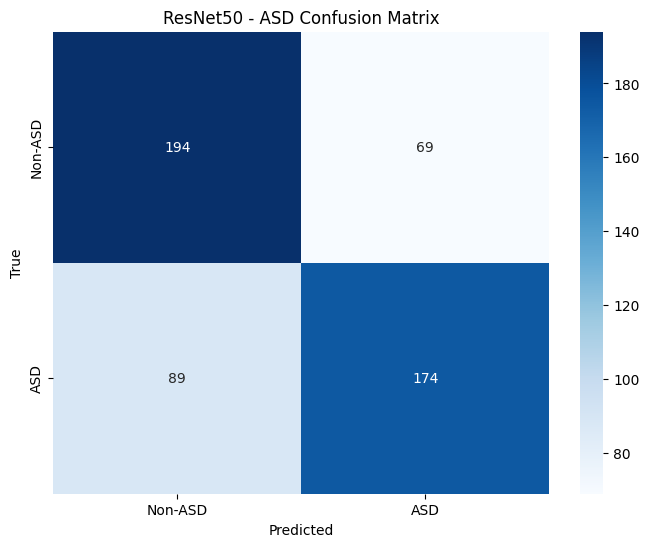

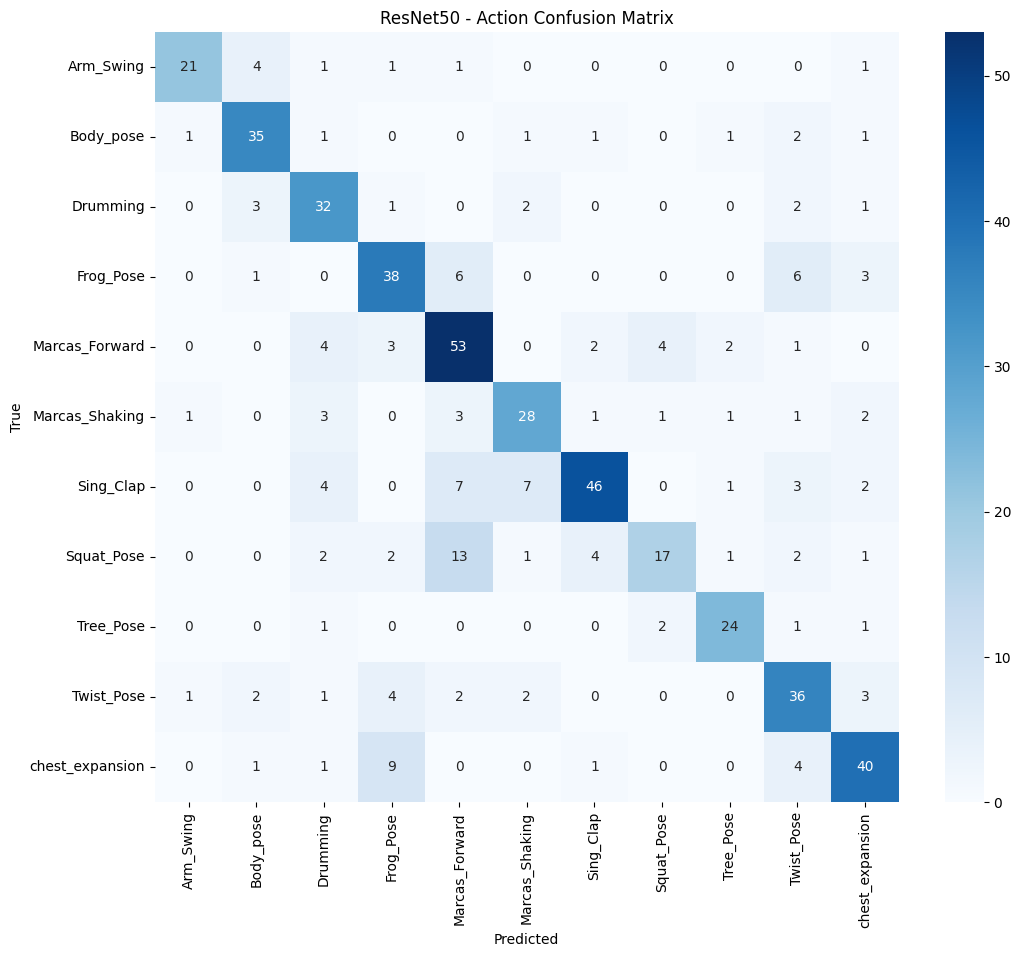


ResNet18 Test ASD Accuracy: 67.30%
ResNet18 Test Action Accuracy: 72.05%
ResNet18 ASD Report:
              precision    recall  f1-score   support

     Non-ASD       0.70      0.60      0.65       263
         ASD       0.65      0.75      0.70       263

    accuracy                           0.67       526
   macro avg       0.68      0.67      0.67       526
weighted avg       0.68      0.67      0.67       526

ResNet18 Action Report:
                 precision    recall  f1-score   support

      Arm_Swing       0.79      0.76      0.77        29
      Body_pose       0.78      0.81      0.80        43
       Drumming       0.73      0.66      0.69        41
      Frog_Pose       0.73      0.74      0.73        54
 Marcas_Forward       0.63      0.74      0.68        69
 Marcas_Shaking       0.56      0.66      0.61        41
      Sing_Clap       0.81      0.67      0.73        70
     Squat_Pose       0.59      0.60      0.60        43
      Tree_Pose       0.83      0.83    

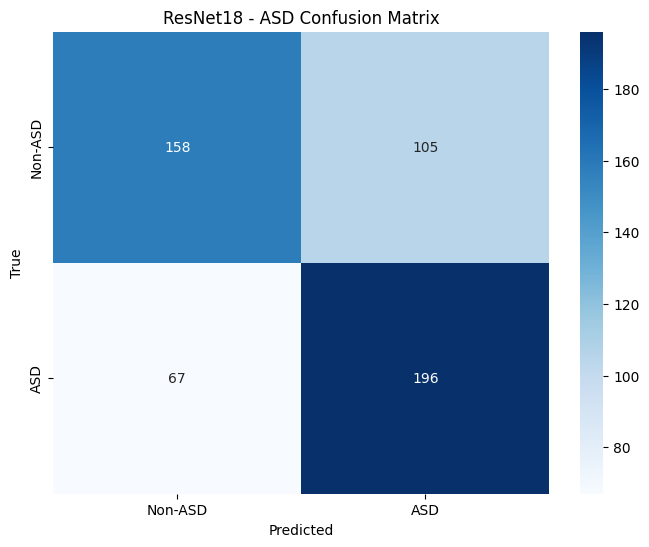

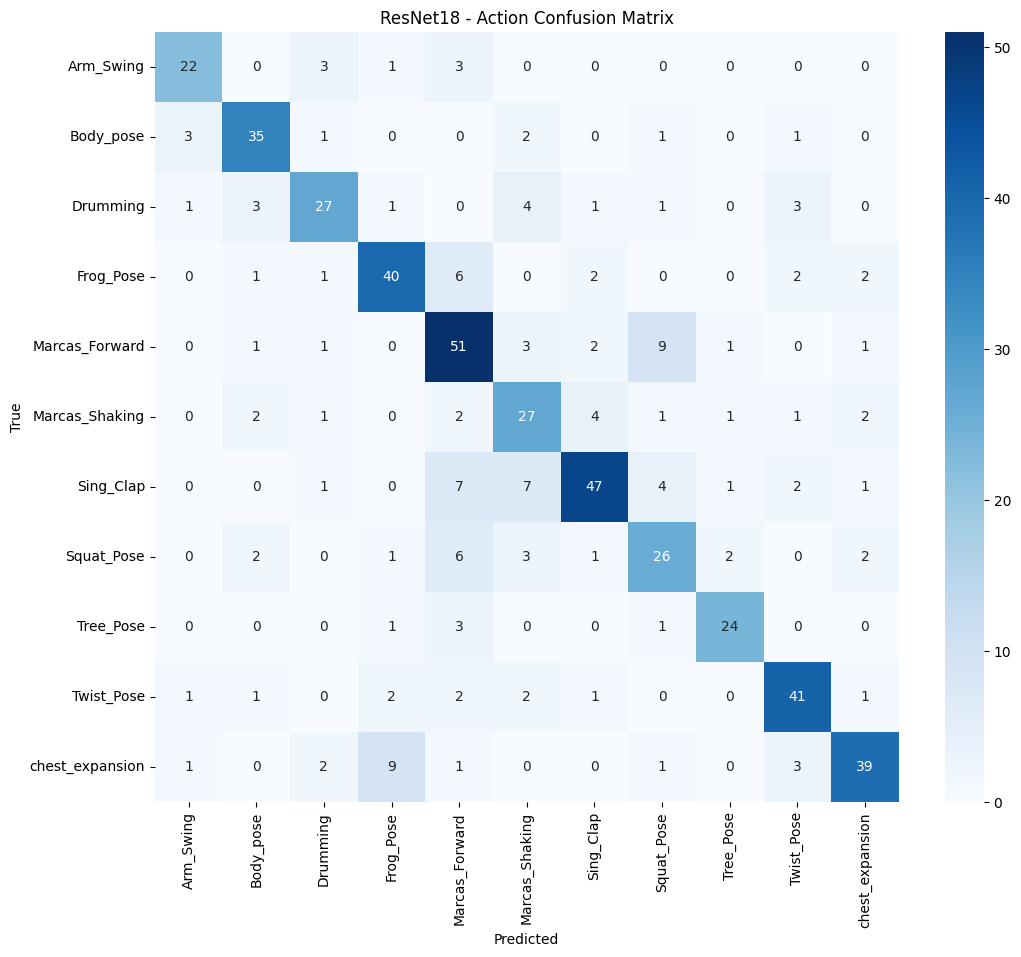


MobileNetV2 Test ASD Accuracy: 71.86%
MobileNetV2 Test Action Accuracy: 67.11%
MobileNetV2 ASD Report:
              precision    recall  f1-score   support

     Non-ASD       0.70      0.77      0.73       263
         ASD       0.74      0.67      0.70       263

    accuracy                           0.72       526
   macro avg       0.72      0.72      0.72       526
weighted avg       0.72      0.72      0.72       526

MobileNetV2 Action Report:
                 precision    recall  f1-score   support

      Arm_Swing       0.88      0.72      0.79        29
      Body_pose       0.65      0.84      0.73        43
       Drumming       0.82      0.80      0.81        41
      Frog_Pose       0.74      0.59      0.66        54
 Marcas_Forward       0.61      0.59      0.60        69
 Marcas_Shaking       0.67      0.63      0.65        41
      Sing_Clap       0.69      0.64      0.67        70
     Squat_Pose       0.51      0.63      0.56        43
      Tree_Pose       0.73  

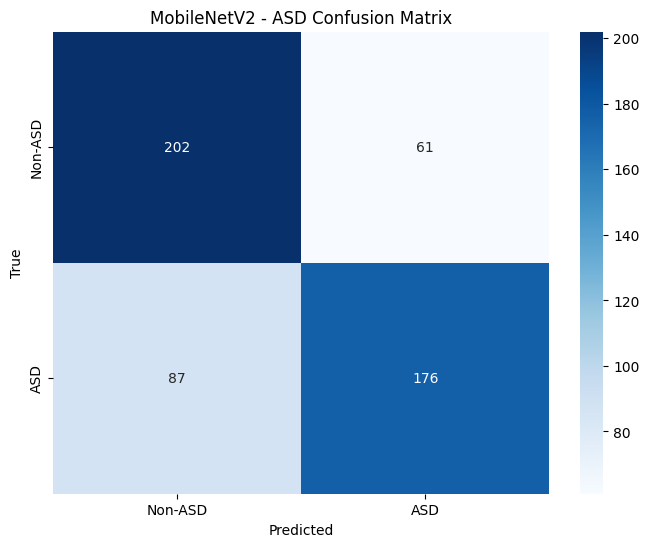

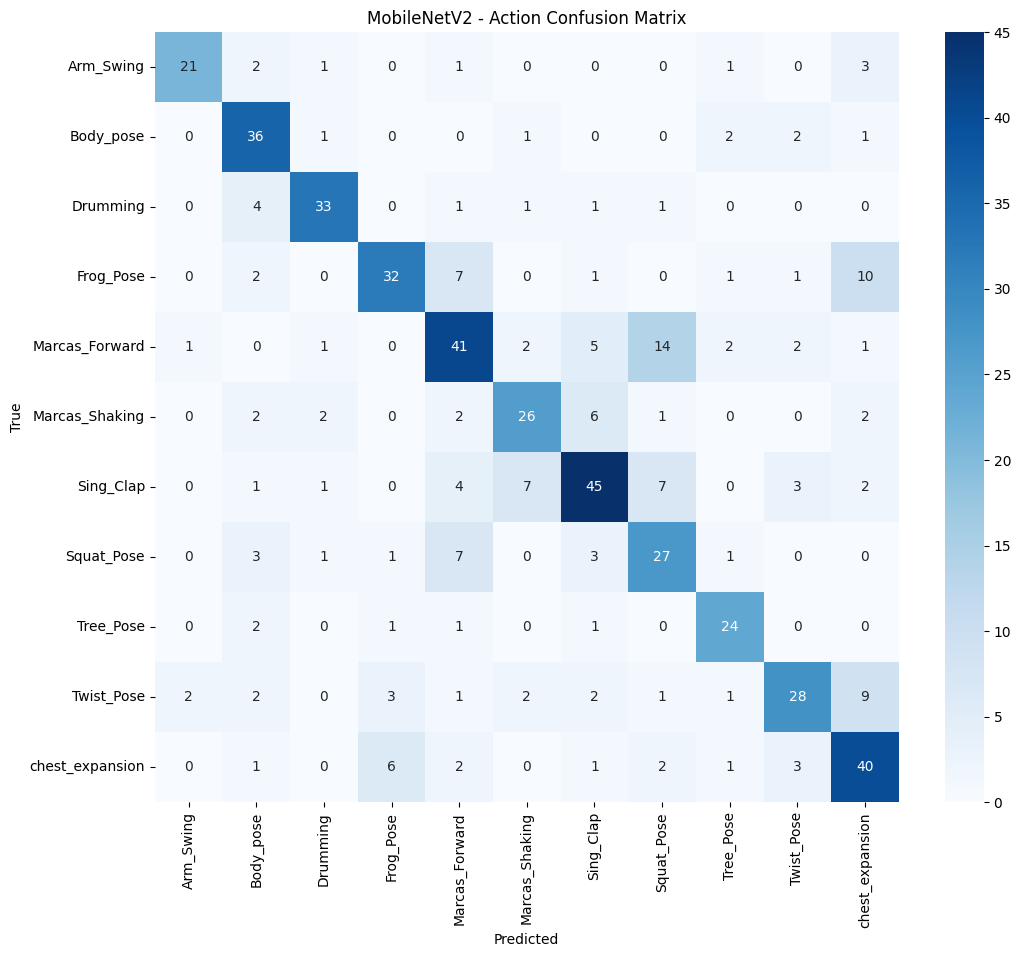


EfficientNet_B0 Test ASD Accuracy: 68.82%
EfficientNet_B0 Test Action Accuracy: 68.25%
EfficientNet_B0 ASD Report:
              precision    recall  f1-score   support

     Non-ASD       0.70      0.66      0.68       263
         ASD       0.68      0.72      0.70       263

    accuracy                           0.69       526
   macro avg       0.69      0.69      0.69       526
weighted avg       0.69      0.69      0.69       526

EfficientNet_B0 Action Report:
                 precision    recall  f1-score   support

      Arm_Swing       0.74      0.69      0.71        29
      Body_pose       0.72      0.79      0.76        43
       Drumming       0.79      0.66      0.72        41
      Frog_Pose       0.64      0.70      0.67        54
 Marcas_Forward       0.63      0.62      0.63        69
 Marcas_Shaking       0.63      0.63      0.63        41
      Sing_Clap       0.68      0.67      0.68        70
     Squat_Pose       0.57      0.58      0.57        43
      Tree_P

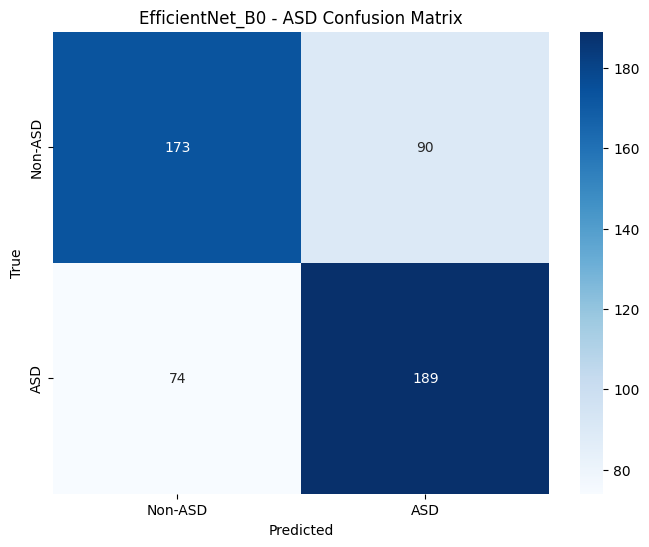

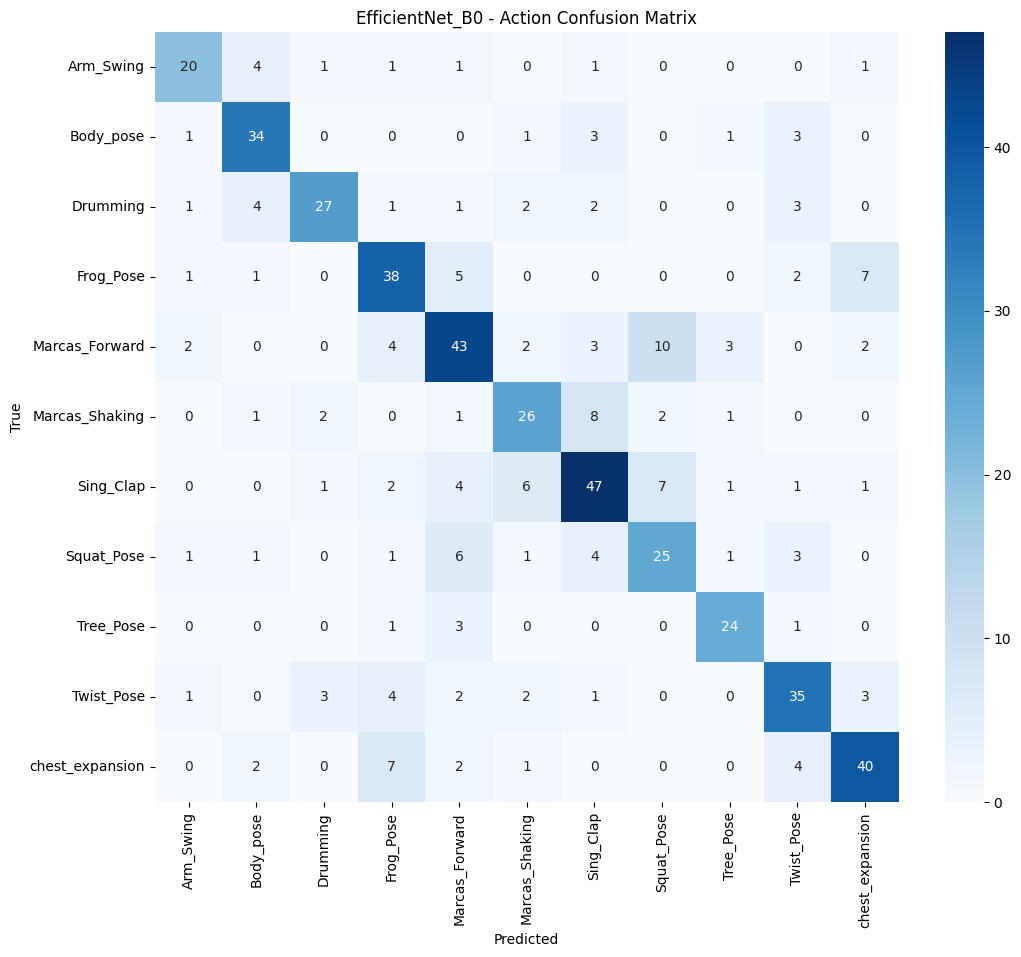

In [35]:
# Evaluation function with confusion matrix
def evaluate_model(model, loader, name):
    model.eval()
    all_asd_labels, all_asd_preds = [], []
    all_action_labels, all_action_preds = [], []
    total_asd, correct_asd, total_action, correct_action = 0, 0, 0, 0

    with torch.no_grad():
        for images, asd_labels, action_labels in loader:
            images, asd_labels, action_labels = images.to(device), asd_labels.to(device), action_labels.to(device)
            asd_outputs, action_outputs = model(images)

            asd_preds = asd_outputs.argmax(1)
            action_preds = action_outputs.argmax(1)

            all_asd_labels.extend(asd_labels.cpu().numpy())
            all_asd_preds.extend(asd_preds.cpu().numpy())
            all_action_labels.extend(action_labels.cpu().numpy())
            all_action_preds.extend(action_preds.cpu().numpy())

            total_asd += asd_labels.size(0)
            correct_asd += (asd_preds == asd_labels).sum().item()
            total_action += action_labels.size(0)
            correct_action += (action_preds == action_labels).sum().item()

    asd_acc = 100 * correct_asd / total_asd
    action_acc = 100 * correct_action / total_action

    print(f"\n{name} Test ASD Accuracy: {asd_acc:.2f}%")
    print(f"{name} Test Action Accuracy: {action_acc:.2f}%")

    print(f"{name} ASD Report:\n" + classification_report(
        all_asd_labels,
        all_asd_preds,
        target_names=['Non-ASD', 'ASD']
    ))

    print(f"{name} Action Report:\n" + classification_report(
        all_action_labels,
        all_action_preds,
        target_names=[
            'Arm_Swing', 'Body_pose', 'Drumming', 'Frog_Pose', 'Marcas_Forward',
            'Marcas_Shaking', 'Sing_Clap', 'Squat_Pose', 'Tree_Pose', 'Twist_Pose',
            'chest_expansion'
        ]
    ))

    # Generate and display confusion matrices
    asd_cm = confusion_matrix(all_asd_labels, all_asd_preds)
    action_cm = confusion_matrix(all_action_labels, all_action_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(asd_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-ASD', 'ASD'], yticklabels=['Non-ASD', 'ASD'])
    plt.title(f"{name} - ASD Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    plt.figure(figsize=(12, 10))
    sns.heatmap(action_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Arm_Swing', 'Body_pose', 'Drumming', 'Frog_Pose', 'Marcas_Forward',
                            'Marcas_Shaking', 'Sing_Clap', 'Squat_Pose', 'Tree_Pose', 'Twist_Pose',
                            'chest_expansion'],
                yticklabels=['Arm_Swing', 'Body_pose', 'Drumming', 'Frog_Pose', 'Marcas_Forward',
                            'Marcas_Shaking', 'Sing_Clap', 'Squat_Pose', 'Tree_Pose', 'Twist_Pose',
                            'chest_expansion'])
    plt.title(f"{name} - Action Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Load best model weights and evaluate
for name, model in models_dict.items():
    model.load_state_dict(best_model_wts[name])
    evaluate_model(model, test_loader, name)